In [10]:
import os
import shutil
import requests
import gzip
import pandas as pd
import sqlite3

from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

url = 'https://bulk.meteostat.net/v2/daily/KGVQ0.csv.gz'
dataset = 'imdevskp/corona-virus-report'

if os.path.exists('data/corona_virus_report'):
    shutil.rmtree('data/corona_virus_report')

if os.path.exists('data/usa_county_wise.csv'):
    os.remove('data/usa_county_wise.csv')

api.dataset_download_files(
    dataset, path='data/corona_virus_report', unzip=True,)

shutil.move('data/corona_virus_report/usa_county_wise.csv', 'data')

covid_data_csv = pd.read_csv('data/usa_county_wise.csv')

shutil.rmtree('data/corona_virus_report')

compressed_file_path = 'KGVQ0.csv.gz'
extracted_file_path = 'KGVQ0.csv'

with requests.get(url, stream=True) as response:
    with open(compressed_file_path, 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)

with gzip.open(compressed_file_path, 'rb') as f_in:
    with open(extracted_file_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

file = pd.read_csv("KGVQ0.csv")

path = 'data'

headerList = ['date', 'tavg', 'tmin', 'tmax', 'prcp',
              'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun']
file.to_csv("KGVQ0.csv", header=headerList, index=False)

file_updated = pd.read_csv("KGVQ0.csv")

connection = sqlite3.connect(os.path.join(path, 'result.db'))
file_updated.to_sql('tempreture', connection, if_exists='replace', index=False)
covid_data_csv.to_sql('covid', connection, if_exists='replace', index=False)

connection.commit()
connection.close()

if os.path.exists(os.path.join(path, 'KGVQ0.csv')):
    os.remove(os.path.join(path, 'KGVQ0.csv'))

shutil.move('KGVQ0.csv', path)
os.remove("KGVQ0.csv.gz")


Dataset URL: https://www.kaggle.com/datasets/imdevskp/corona-virus-report
Data pipeline executed successfully.


C:\Users\hatef\AppData\Local\Temp\ipykernel_25432\1922783540.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  covid_data_alabama['Date'] = pd.to_datetime(covid_data_alabama['Date'])


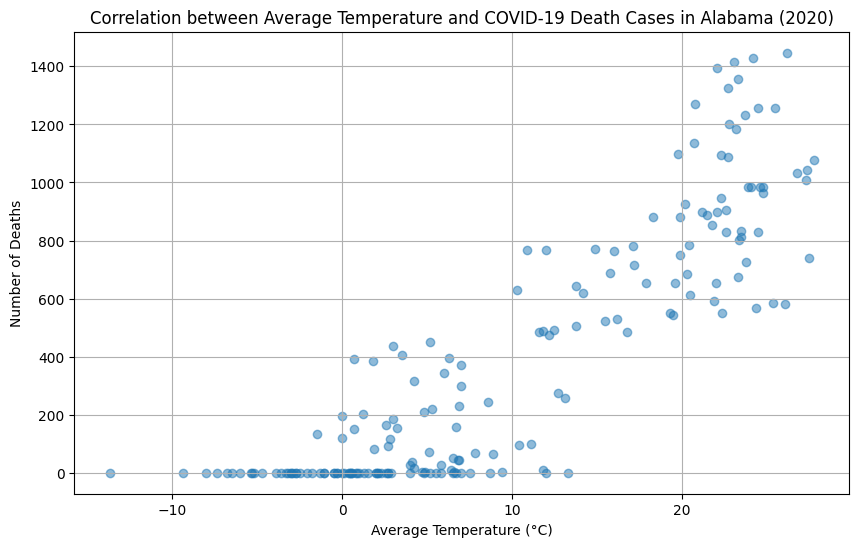

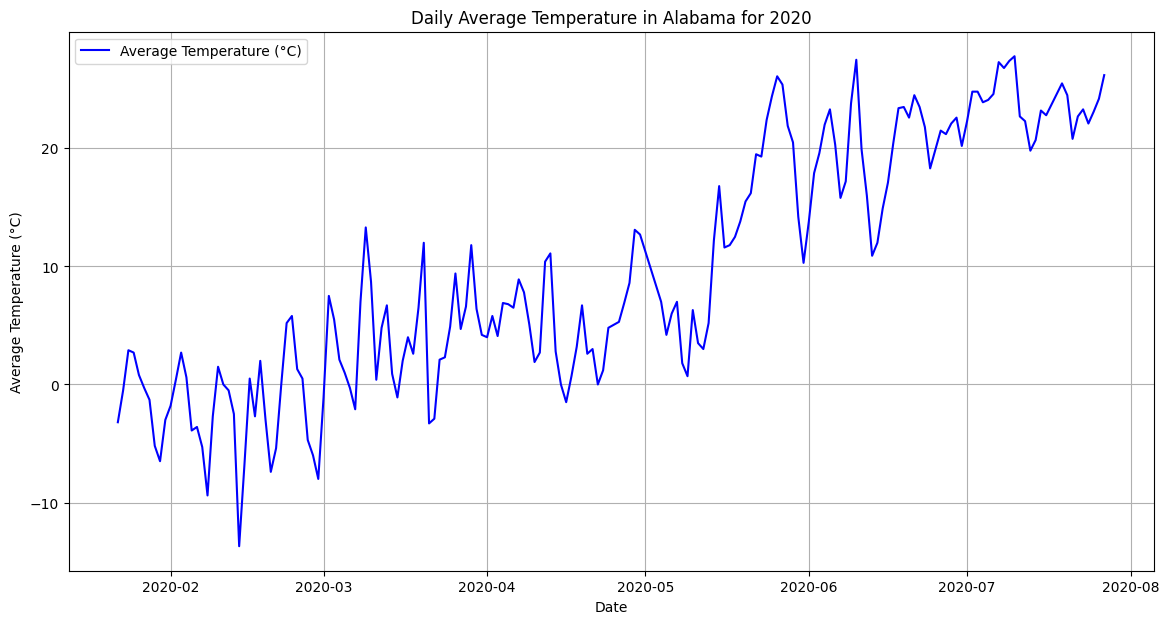

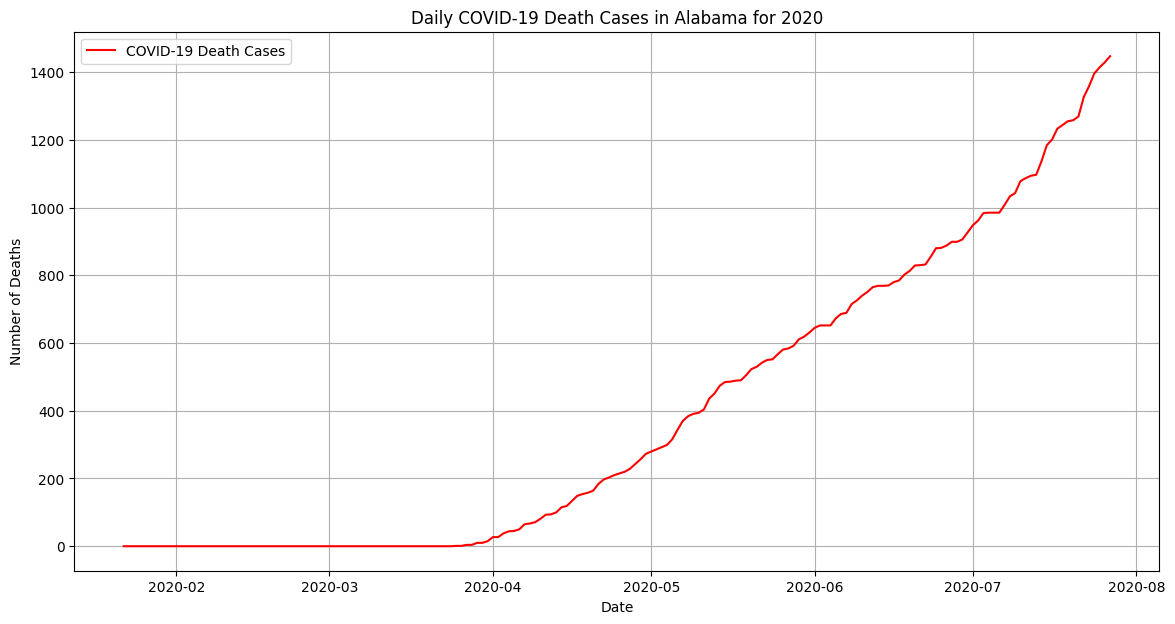

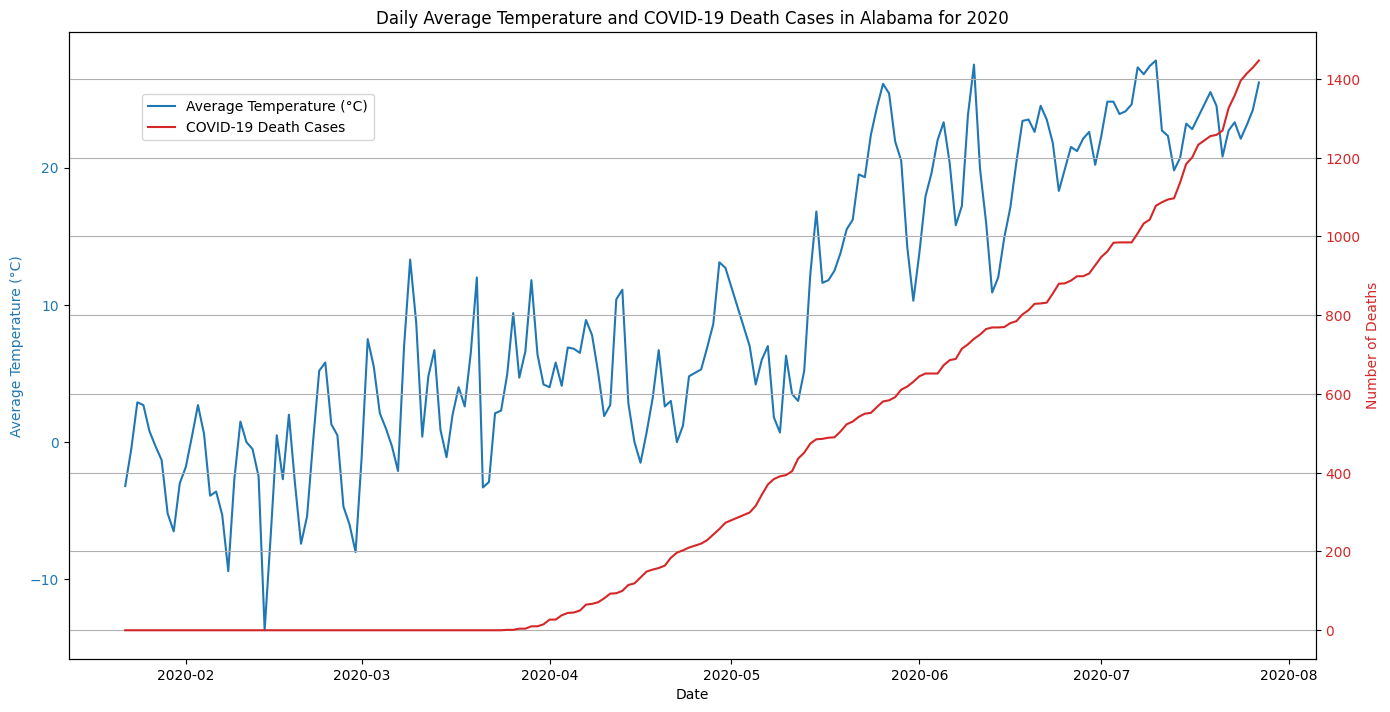

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

weather_data = file_updated
covid_data = covid_data_csv

weather_data.columns = ['date', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun']
weather_data['date'] = pd.to_datetime(weather_data['date'])
weather_data_alabama = weather_data[(weather_data['date'] >= '2020-01-01') & (weather_data['date'] < '2021-01-01')]
weather_data_alabama = weather_data_alabama[['date', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'pres', 'tsun']].groupby('date').mean().reset_index()

covid_data_alabama = covid_data[(covid_data['Province_State'] == 'Alabama')]
covid_data_alabama = covid_data_alabama[['Date', 'Deaths']].groupby('Date').sum().reset_index()
covid_data_alabama['Date'] = pd.to_datetime(covid_data_alabama['Date'])
covid_data_alabama.columns = ['date', 'deaths']

merged_data = pd.merge(weather_data_alabama, covid_data_alabama, on='date', how='inner')

merged_data.to_csv('data/alabama_covid_weather.csv', index=False)

plt.figure(figsize=(10, 6))
plt.scatter(merged_data['tavg'], merged_data['deaths'], alpha=0.5)
plt.title('Correlation between Average Temperature and COVID-19 Death Cases in Alabama (2020)')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Number of Deaths')
plt.grid(True)
plt.show()


plt.figure(figsize=(14, 7))
plt.plot(merged_data['date'], merged_data['tavg'], label='Average Temperature (°C)', color='blue')
plt.title('Daily Average Temperature in Alabama for 2020')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(merged_data['date'], merged_data['deaths'], label='COVID-19 Death Cases', color='red')
plt.title('Daily COVID-19 Death Cases in Alabama for 2020')
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.legend()
plt.grid(True)
plt.show()

fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Temperature (°C)', color=color)
ax1.plot(merged_data['date'], merged_data['tavg'], label='Average Temperature (°C)', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Number of Deaths', color=color)
ax2.plot(merged_data['date'], merged_data['deaths'], label='COVID-19 Death Cases', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Daily Average Temperature and COVID-19 Death Cases in Alabama for 2020')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.grid(True)
plt.show()
